In [15]:
# Goals:
#     - Get the puffer data in
#     - Understand the puffer paper
#     - Train Random Forest on the puffer data based on Richard's work

In [16]:
import os
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset folders
# dataset_list = ['video_sent_2025-05-19T11_2025-05-20T11']
dataset_list = ['video_sent_2019-01-26T11_2019-01-27T11']

current_dir = os.getcwd()
base_path = '' + current_dir + '/puffer_tests/'
print(base_path)
# base_path = './test_data'

# Quality labels to predict
quality_labels = ['144', '240', '360', '480', '720', '1080', '1440', '2160']

# Collect all merged CSVs
all_dfs = []
print("Loading CSV files...")
for dataset in tqdm(dataset_list, desc="Datasets"):
    file_path = os.path.join(base_path + dataset + '.csv')  # <-- match all CSVs
    
    try:
        df = pd.read_csv(file_path, dtype=str)
        print(f"Loaded {file_path} with shape {df.shape}")
        df['source_dataset'] = dataset  # Optional: keep track of source
        all_dfs.append(df)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
# # Combine all data

/Users/Bryce/CS293N/293N-YT-ABR-Prediction/puffer_tests/
Loading CSV files...


Datasets: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]

Loaded /Users/Bryce/CS293N/293N-YT-ABR-Prediction/puffer_tests/video_sent_2019-01-26T11_2019-01-27T11.csv with shape (1235841, 14)


In [17]:
print(all_dfs)

[               time (ns GMT)                                    session_id  \
0        1548500400788000000  u9x7414eluleHfu/Yj/zN+kBoR0qhsLoTS3q8eY/cDw=   
1        1548500401993000000  gfBnNIFYhijf3b8HjWg5bJ6njmmsabACcbc0BoOoZq0=   
2        1548500402853000000  u9x7414eluleHfu/Yj/zN+kBoR0qhsLoTS3q8eY/cDw=   
3        1548500402957000000  gfBnNIFYhijf3b8HjWg5bJ6njmmsabACcbc0BoOoZq0=   
4        1548500404848000000  u9x7414eluleHfu/Yj/zN+kBoR0qhsLoTS3q8eY/cDw=   
...                      ...                                           ...   
1235836  1548586066020000000  u6oPTyb9copR7Buqvetl8/KNXHUX+PSPQrixfmIdqhk=   
1235837  1548560389652000000  W8A7es6qMDphBOGi0wzrZoUsBtJKyiP1QB0DiNrENJw=   
1235838  1548517377509000000  spRnPmWrYUDvrn5kxMhk9rSvNIaocokyBTablH7kJJQ=   
1235839  1548558675957000000  7VOqbt13IfuPQPJ0E1U6F/6uDJfPDZMXaekO8BfZaeQ=   
1235840  1548574822857000000  OsTzlVCSIKKWtzOf9qg/K/jb1Khj/byCzvNY4ZFJRoc=   

        index expt_id channel     video_ts        format     s

In [18]:
print("Combining CSVs into one DataFrame...")
data = pd.concat(all_dfs, ignore_index=True)
print(f"Total rows loaded: {len(data)}")
print(data.columns)

Combining CSVs into one DataFrame...
Total rows loaded: 1235841
Index(['time (ns GMT)', 'session_id', 'index', 'expt_id', 'channel',
       'video_ts', 'format', 'size', 'ssim_index', 'cwnd', 'in_flight',
       'min_rtt', 'rtt', 'delivery_rate', 'source_dataset'],
      dtype='object')


In [19]:
quality_to_index = {q: i for i, q in enumerate(quality_labels)}

def extract_first_number(s):
    return s.split('x')[1].split('-')[0]

#data['PlaybackQuality'] = df_numeric.idxmax(axis=1).map(quality_to_index)

df_numeric = data[['format']].applymap(lambda x: extract_first_number(x))
#df_numeric
data['PlaybackQuality'] = df_numeric['format'].map(quality_to_index)



In [20]:
print("Filtering out rows with no quality label...")
data = data.dropna(subset=['PlaybackQuality'])

Filtering out rows with no quality label...


In [21]:
data

,time (ns GMT),session_id,index,expt_id,channel,video_ts,format,size,ssim_index,cwnd,in_flight,min_rtt,rtt,delivery_rate,source_dataset,PlaybackQuality
0,1548500400788000000,u9x7414eluleHfu/Yj/zN+kBoR0qhsLoTS3q8eY/cDw=,0,232,abc,38279961720,1280x720-20,579932,0.981149,294,0,75936,109157,669806,video_sent_2019-01-26T11_2019-01-27T11,4
1,1548500401993000000,gfBnNIFYhijf3b8HjWg5bJ6njmmsabACcbc0BoOoZq0=,0,237,abc,38280322080,1280x720-20,269778,0.986832,846,0,53162,70263,10908953,video_sent_2019-01-26T11_2019-01-27T11,4
2,1548500402853000000,u9x7414eluleHfu/Yj/zN+kBoR0qhsLoTS3q8eY/cDw=,0,232,abc,38280141900,1280x720-20,475807,0.983754,295,0,75936,104773,2900000,video_sent_2019-01-26T11_2019-01-27T11,4
3,1548500402957000000,gfBnNIFYhijf3b8HjWg5bJ6njmmsabACcbc0BoOoZq0=,0,237,abc,38280502260,1280x720-20,322657,0.986481,846,0,53162,72590,10908953,video_sent_2019-01-26T11_2019-01-27T11,4
4,1548500404848000000,u9x7414eluleHfu/Yj/zN+kBoR0qhsLoTS3q8eY/cDw=,0,232,abc,38280322080,1280x720-20,269778,0.986832,296,0,75936,114102,3839571,video_sent_2019-01-26T11_2019-01-27T11,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235836,1548586066020000000,u6oPTyb9copR7Buqvetl8/KNXHUX+PSPQrixfmIdqhk=,15,288,pbs,45986080140,1920x1080-22,472355,0.987728,45,0,73202,84268,750651,video_sent_2019-01-26T11_2019-01-27T11,5
1235837,1548560389652000000,W8A7es6qMDphBOGi0wzrZoUsBtJKyiP1QB0DiNrENJw=,9,272,abc,43680496860,1280x720-20,2004140,0.970988,245,0,74572,88115,17089,video_sent_2019-01-26T11_2019-01-27T11,4
1235838,1548517377509000000,spRnPmWrYUDvrn5kxMhk9rSvNIaocokyBTablH7kJJQ=,5,240,cbs,39804284520,1920x1080-22,1289457,0.981937,67,0,77691,102111,916244,video_sent_2019-01-26T11_2019-01-27T11,5
1235839,1548558675957000000,7VOqbt13IfuPQPJ0E1U6F/6uDJfPDZMXaekO8BfZaeQ=,15,272,cbs,43516533060,426x240-26,41315,0.840662,25,0,183000,184078,125780,video_sent_2019-01-26T11_2019-01-27T11,1


In [22]:
# Wrap in tqdm for progress bar
for col in tqdm(data.columns, desc="Converting columns to numeric"):
    data[col] = pd.to_numeric(data[col], errors='ignore')
print(data)

Converting columns to numeric: 100%|████████████| 16/16 [00:04<00:00,  3.93it/s]

               time (ns GMT)                                    session_id  \
0        1548500400788000000  u9x7414eluleHfu/Yj/zN+kBoR0qhsLoTS3q8eY/cDw=   
1        1548500401993000000  gfBnNIFYhijf3b8HjWg5bJ6njmmsabACcbc0BoOoZq0=   
2        1548500402853000000  u9x7414eluleHfu/Yj/zN+kBoR0qhsLoTS3q8eY/cDw=   
3        1548500402957000000  gfBnNIFYhijf3b8HjWg5bJ6njmmsabACcbc0BoOoZq0=   
4        1548500404848000000  u9x7414eluleHfu/Yj/zN+kBoR0qhsLoTS3q8eY/cDw=   
...                      ...                                           ...   
1235836  1548586066020000000  u6oPTyb9copR7Buqvetl8/KNXHUX+PSPQrixfmIdqhk=   
1235837  1548560389652000000  W8A7es6qMDphBOGi0wzrZoUsBtJKyiP1QB0DiNrENJw=   
1235838  1548517377509000000  spRnPmWrYUDvrn5kxMhk9rSvNIaocokyBTablH7kJJQ=   
1235839  1548558675957000000  7VOqbt13IfuPQPJ0E1U6F/6uDJfPDZMXaekO8BfZaeQ=   
1235840  1548574822857000000  OsTzlVCSIKKWtzOf9qg/K/jb1Khj/byCzvNY4ZFJRoc=   

         index  expt_id channel     video_ts        format     

In [23]:
# Drop original quality columns
data = data.drop(columns=['format'])
print(data)
# # Drop non-numeric BECAUSE RF DOESNT WORK ON NON NUMERICS
# non_feature_cols = ['IPSrc0', 'IPDst0', 'Protocol0', 'source_dataset',
#                     'CollectData', 'StartTime', 'UnlabelledQuality']
# data = data.drop(columns=[col for col in non_feature_cols if col in data.columns], errors='ignore')

# # Remove IP and protocol columns (non-numeric)
# data = data[[col for col in data.columns if not any(proto in col for proto in ['IPSrc', 'IPDst', 'Protocol'])]]

# Drop any remaining non-numeric columns
data = data.select_dtypes(include=['number', 'bool'])
print(data)

               time (ns GMT)                                    session_id  \
0        1548500400788000000  u9x7414eluleHfu/Yj/zN+kBoR0qhsLoTS3q8eY/cDw=   
1        1548500401993000000  gfBnNIFYhijf3b8HjWg5bJ6njmmsabACcbc0BoOoZq0=   
2        1548500402853000000  u9x7414eluleHfu/Yj/zN+kBoR0qhsLoTS3q8eY/cDw=   
3        1548500402957000000  gfBnNIFYhijf3b8HjWg5bJ6njmmsabACcbc0BoOoZq0=   
4        1548500404848000000  u9x7414eluleHfu/Yj/zN+kBoR0qhsLoTS3q8eY/cDw=   
...                      ...                                           ...   
1235836  1548586066020000000  u6oPTyb9copR7Buqvetl8/KNXHUX+PSPQrixfmIdqhk=   
1235837  1548560389652000000  W8A7es6qMDphBOGi0wzrZoUsBtJKyiP1QB0DiNrENJw=   
1235838  1548517377509000000  spRnPmWrYUDvrn5kxMhk9rSvNIaocokyBTablH7kJJQ=   
1235839  1548558675957000000  7VOqbt13IfuPQPJ0E1U6F/6uDJfPDZMXaekO8BfZaeQ=   
1235840  1548574822857000000  OsTzlVCSIKKWtzOf9qg/K/jb1Khj/byCzvNY4ZFJRoc=   

         index  expt_id channel     video_ts     size  ssim_ind

In [24]:
# Encode labels
le = LabelEncoder()
data['PlaybackQuality'] = le.fit_transform(data['PlaybackQuality'])

# Separate features and labels
X = data.drop(columns=['PlaybackQuality'])
y = data['PlaybackQuality']


In [25]:
print(y)
print(X)

0          3
1          3
2          3
3          3
4          3
          ..
1235836    4
1235837    3
1235838    4
1235839    0
1235840    4
Name: PlaybackQuality, Length: 1235841, dtype: int64
               time (ns GMT)  index  expt_id     video_ts     size  \
0        1548500400788000000      0      232  38279961720   579932   
1        1548500401993000000      0      237  38280322080   269778   
2        1548500402853000000      0      232  38280141900   475807   
3        1548500402957000000      0      237  38280502260   322657   
4        1548500404848000000      0      232  38280322080   269778   
...                      ...    ...      ...          ...      ...   
1235836  1548586066020000000     15      288  45986080140   472355   
1235837  1548560389652000000      9      272  43680496860  2004140   
1235838  1548517377509000000      5      240  39804284520  1289457   
1235839  1548558675957000000     15      272  43516533060    41315   
1235840  1548574822857000000     1

In [26]:

# Split
print("Splitting into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
print("Training Random Forest Classifier...")
clf = RandomForestClassifier(n_estimators=10, random_state=42)
for i in tqdm(range(1), desc="Training"):
    clf.fit(X_train, y_train)

# Evaluate
print("\nEvaluating model...")
y_pred = clf.predict(X_test)

Splitting into training and test sets...
Training Random Forest Classifier...


Training: 100%|███████████████████████████████████| 1/1 [00:28<00:00, 28.72s/it]



Evaluating model...


In [27]:
print(le.classes_.astype(str))

['1' '2' '3' '4' '5']



Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.89      0.95      0.92      6113
           3       0.69      0.60      0.64      2818
           4       0.69      0.58      0.63      5155
           5       0.95      0.94      0.95    102946

   micro avg       0.93      0.92      0.93    117032
   macro avg       0.64      0.62      0.63    117032
weighted avg       0.93      0.92      0.92    117032



/Users/Bryce/anaconda3/envs/trustee/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Bryce/anaconda3/envs/trustee/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Bryce/anaconda3/envs/trustee/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

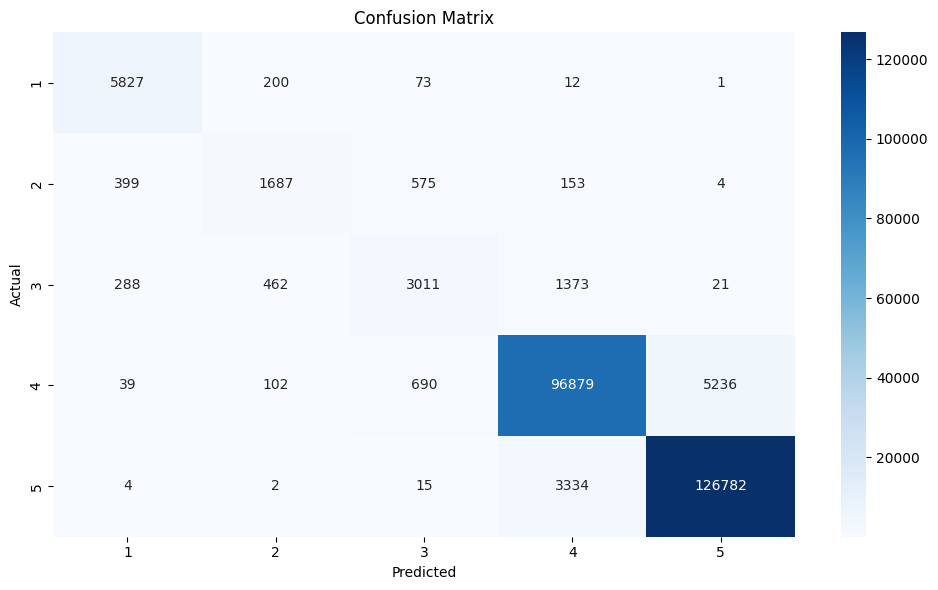

In [28]:
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, target_names=le.classes_))
# Convert the integer labels back to string labels
y_test_str = le.inverse_transform(y_test)
y_pred_str = le.inverse_transform(y_pred)

# Classification report with string labels
print("\nClassification Report:")
print(classification_report(y_test_str, y_pred_str, labels=range(len(le.classes_)), target_names=le.classes_.astype(str)))
# Confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [14]:
from trustee import ClassificationTrustee

# Apply ClassificationTrustee
trustee = ClassificationTrustee(expert=clf)

# Fit the trustee model to the training data
trustee.fit(X_train, y_train, num_iter=2, num_stability_iter=2, samples_size=0.3, verbose=True)

# Get the explanation (decision tree and other metrics)
dt, pruned_dt, agreement, reward = trustee.explain()

# Predict using the pruned decision tree
dt_y_pred = dt.predict(X_test)

# Print the global fidelity report
print("Model explanation global fidelity report:")
print(classification_report(y_pred, dt_y_pred))

# Print the explanation score report
print("Model explanation score report:")
print(classification_report(y_test, dt_y_pred))

Initializing training dataset using RandomForestClassifier(n_estimators=10, random_state=42) as expert model
Expert model score: 0.9940752728921105
Initializing Trustee outer-loop with 2 iterations
########## Outer-loop Iteration 0/2 ##########
Initializing Trustee inner-loop with 2 iterations
########## Inner-loop Iteration 0/2 ##########
Sampling 207621 points from training dataset with (692070, 692070) entries
Student model 0-0 trained with depth 39 and 10305 leaves:
Student model score: 0.7325767100625971
Student model 0-0 fidelity: 0.7325767100625971
########## Inner-loop Iteration 1/2 ##########
Sampling 207621 points from training dataset with (754357, 754357) entries
Student model 0-1 trained with depth 38 and 10231 leaves:
Student model score: 0.7453086887449538
Student model 0-1 fidelity: 0.7453086887449538
########## Outer-loop Iteration 1/2 ##########
Initializing Trustee inner-loop with 2 iterations
########## Inner-loop Iteration 0/2 ##########
Sampling 207621 points from

/Users/Bryce/anaconda3/envs/trustee/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Model explanation global fidelity report:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      6557
           1       0.47      0.55      0.51      2453
           2       0.49      0.58      0.53      4364
           3       0.90      0.91      0.91    101751
           4       0.94      0.93      0.94    132044

    accuracy                           0.91    247169
   macro avg       0.74      0.76      0.75    247169
weighted avg       0.91      0.91      0.91    247169

Model explanation score report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      6113
           1       0.47      0.48      0.48      2818
           2       0.50      0.49      0.49      5155
           3       0.89      0.89      0.89    102946
           4       0.93      0.93      0.93    130137

    accuracy                           0.90    247169
   macro avg       0.73      0.73      0.73    247169
wei

In [ ]:
# This one might actually work?
from trustee.report.trust import TrustReport

OUTPUT_PATH = "./test"

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

target_names = [str(name) for name in y.unique()]  # Convert target labels to strings
feature_names = X.columns.tolist()  # Feature column names

trust_report = TrustReport(
    clf,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    max_iter=1,
    num_pruning_iter=1,
    train_size=0.7,
    trustee_num_iter=1,
    trustee_num_stability_iter=1,
    trustee_sample_size=0.3,
    analyze_branches=True,
    analyze_stability=True,
    top_k=1,
    verbose=True,
    class_names=target_names,
    feature_names=feature_names,
    is_classify=True,
)

print(trust_report)
trust_report.save(OUTPUT_PATH)